# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. 

Необходимо построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План выполнения работы


1. Подготовка данных:

 - Первичный аналитический осмотр данных;
 - Предобработка данных;
 
 
2. Исследовательский анализ данных:

 - Исследование распределений данных;
 - Проверка данных на мультиколлинеарность;


3. Подготовка признаков для обучения моделей ML:

 - Разделение данных на выборки;
 - Масштабирование данных для исключения придания моделями больших весов отдельным признакам;
 - Отсев пар признаков с высокой корреляцией;
 
 
4. Обучение и выбор наиболее перспективных моделей ML:

 - Подбор гиперпараметров модели для достижения наилучшей метрики качества;
 - Проверка моделей на адекватность ( сравнение с Dummy-моделью )
 
 
5. Тестирование наиболее перспективных моделей на тестовой выборке:

 - С точки зрения метрики качества;
 - С точки зрения времени обучения;
 
 
6. Исследование значимости признаков;
 
 
7. Оформление финального отчета.

## Подготовка данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFECV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings

Загрузим данные:

In [2]:
def load_data(data_name):
#     data = pd.read_csv('/Users/nzinchenko/Downloads/final_steel/'+ data_name)
    data = pd.read_csv('/datasets/final_steel/'+ data_name)
    data.name = data_name.split('.csv')[0]
    return data

In [3]:
for name in [
    'data_arc',
    'data_bulk',
    'data_bulk_time',
    'data_gas',
    'data_temp',
    'data_wire',
    'data_wire_time'
]:
    locals()[name] = load_data(name+'.csv')

Далее изучим загруженные данные.

### Первичный аналитический осмотр данных

Напишем функцию для первичного аналитического осмотра.

Проверим формат названий столбцов каждого из загруженных датасетов:

In [4]:
def check_names():
    for data in [
        data_arc,
        data_bulk,
        data_bulk_time,
        data_gas, data_temp,
        data_wire,
        data_wire_time
    ]:
        print(
            '\033[1m' + data.name + '\033[0m',
            '\n',
            '\n',
            data.columns,
            '\n'
        )
        
check_names()

data_arc 
 
 Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object') 

data_bulk 
 
 Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object') 

data_bulk_time 
 
 Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object') 

data_gas 
 
 Index(['key', 'Газ 1'], dtype='object') 

data_temp 
 
 Index(['key', 'Время замера', 'Температура'], dtype='object') 

data_wire 
 
 Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object') 

data_wire_time 
 
 Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 

Как видно из выведенной на экран информации, названия столбцов в датасетах не приведены к одному формату.
Для удобства дальнейшей рабоы приведем названия в соответствие: используем только строчные латинские буквы и не будем использовать в названиях пробелы.

Ннапишем функцию для форматирования названий столбцов:

In [5]:
def format_names(data, dic):
    data.rename(columns = dic, inplace = True)
    data.columns = data.columns.str.lower()
    data.columns = data.columns.str.replace(' ', '_')

Применим функцию:

In [6]:
format_names(
    data_arc,
    {'Начало нагрева дугой': 'heating_start',
     'Конец нагрева дугой': 'heating_end',
     'Активная мощность': 'power_active',
     'Реактивная мощность': 'power_reactive'}
)

format_names(data_bulk,{})
format_names(data_bulk_time,{})
format_names(data_gas,{'Газ 1': 'gas'})
format_names(data_temp,{'Время замера': 'metering_time', 'Температура':'temp'})
format_names(data_wire,{})
format_names(data_wire_time,{})

Проверим результат форматирования:

In [7]:
check_names()

data_arc 
 
 Index(['key', 'heating_start', 'heating_end', 'power_active',
       'power_reactive'],
      dtype='object') 

data_bulk 
 
 Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object') 

data_bulk_time 
 
 Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object') 

data_gas 
 
 Index(['key', 'gas'], dtype='object') 

data_temp 
 
 Index(['key', 'metering_time', 'temp'], dtype='object') 

data_wire 
 
 Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object') 

data_wire_time 
 
 Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='objec

In [8]:
def initial_analysis(data_1,data_2):
    
    bold = '\033[1m'
    end = '\033[0m'
    
    print('\n' + 'Вывод на экран первых 5 строк датасета(ов):')
    print('\n' + bold + data_1.name + end)
    display(data_1.head())
    if data_2 is not None:
        print('\n', bold + data_2.name + end)
        display(data_2.head())
        
    print('\n' + 'Вывод на экран общей информации о данных:' + '\n')   
    print(bold + data_1.name + end,'\n')   
    data_1.info()
    if data_2 is not None:
        print('\n' + bold + data_2.name + end + '\n')
        data_2.info()
        
    print('\n' + 'Вывод на экран описательной статистики данных:' + '\n')   
    print(bold + data_1.name + end)   
    display(data_1.describe())
        
    print('\n' + 'Проверка данных на наличие грубых дубликатов:')
    print('\n' + bold + f'{data_1.name}' + end + ':',
          data_1.duplicated().sum()
         )
    if data_2 is not None:
        print(bold + f'{data_2.name}' + end + ':',
              data_2.duplicated().sum()
             )
        
    print('\n' + 'Расчет количества партий расплава в датасете(ах):')
    print('\n' + bold + f'{data_1.name}' + end + ':',
          len(data_1['key'].unique())
         )
    if data_2 is not None:
        print(bold + f'{data_2.name}' + end + ':',
              len(data_1['key'].unique())
             )

#### Данные об электродах

In [9]:
initial_analysis(data_arc, None)


Вывод на экран первых 5 строк датасета(ов):

data_arc


,key,heating_start,heating_end,power_active,power_reactive
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



Вывод на экран общей информации о данных:

data_arc 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key               14876 non-null int64
heating_start     14876 non-null object
heating_end       14876 non-null object
power_active      14876 non-null float64
power_reactive    14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Вывод на экран описательной статистики данных:

data_arc


,key,power_active,power_reactive
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388



Проверка данных на наличие грубых дубликатов:

data_arc: 0

Расчет количества партий расплава в датасете(ах):

data_arc: 3214


Из описательной статистики видно, что в столбце ***power_reactive*** присутствуют отрицательные значения. Рассмотрим подробнее строки с отрицательной реактивной мощностью:

In [10]:
data_arc[data_arc['power_reactive'] < 0]

,key,heating_start,heating_end,power_active,power_reactive
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


###### Вывод

Всего в датасете 14 876 строк и 5 столбцов со следующими типами данных: *float64, int64, object*.

Каждая строка датасета содержит информацию о начале и конце нагрева партии расплава электродами и о потребленной электрической мощности в ходе одной итерации.

В датасете содержится информация о температурной обработке 3 214 партий расплава.

В датасете не обнаружены пропуски данных и грубые дубликаты.

Столбец ***power_reactive*** содержит одно отрицательное значение, являющееся, вероятнее всего, выбросом, т.к, отрицательная реактивная мощность означает, что устройство ее не потребляет, а, условно, производит, что, в данном процессе невозможно. Кроме того, показатель активной мощности в той же строке отражен корректно. 

Так как реактивная составляющая электрического тока возникает только в цепях, содержащих реактивные элементы и расходуется обычно на бесполезный нагрев проводников, из которых составлена эта цепь, далее в работе не будем использовать эти данные в качестве признака.

Тип данных столбцов ***heating_start*** и ***heating_end*** - *object*, не соответствует отражаемым в столбцах данным. Необходимо изменить тип данных указанных столбцов на *datetime*.

#### Данные о подаче сыпучих материалов 

In [11]:
initial_analysis(data_bulk, data_bulk_time)


Вывод на экран первых 5 строк датасета(ов):

data_bulk


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



 data_bulk_time


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Вывод на экран общей информации о данных:

data_bulk 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
bulk_1     252 non-null float64
bulk_2     22 non-null float64
bulk_3     1298 non-null float64
bulk_4     1014 non-null float64
bulk_5     77 non-null float64
bulk_6     576 non-null float64
bulk_7     25 non-null float64
bulk_8     1 non-null float64
bulk_9     19 non-null float64
bulk_10    176 non-null float64
bulk_11    177 non-null float64
bulk_12    2450 non-null float64
bulk_13    18 non-null float64
bulk_14    2806 non-null float64
bulk_15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

data_bulk_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
bulk_1     252 non-null object
bulk_2     22 non-null object
bulk_3     1298 non-null object
bulk_4     1014 non-null ob

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Проверка данных на наличие грубых дубликатов:

data_bulk: 0
data_bulk_time: 0

Расчет количества партий расплава в датасете(ах):

data_bulk: 3129
data_bulk_time: 3129


###### Вывод

Всего в датасетах 3 129 строк и 16 столбцов со следующими типами данных: *int64, object*.

Каждая строка датасета ***data_bulk*** содержит информацию о внесении в одну партию расплава одной или нескольких из 15 разновидностей сыпучих материалов.

Каждая строка датасета ***data_bulk_time*** содержит информацию о времени внесения в одну партию расплава одной или нескольких из 15 разновидностей сыпучих материалов.

В датасете содержится информация о температурной обработке 3 129 партий расплава, что отличается от количества партий, подвергшихся нагреванию с помощью электродов. Это может быть связано с тем, что не в каждую партию расплава вносились сыпучие материалы.

В датасетах обнаружены пропуски данных. Названия столбцов, а также пропуски в каждом из столбцов идентичны в обоих датасетах и, вероятнее всего, связаны с периодическим использованием того или иного вида сыпучих материалов. Вполне логично провести замену пропущенных значений нулями.

Грубые дубликаты в рассматриваемых датасетах не обнаружены.

Тип данных столбцов ***data_bulk_time***, содержащих информацию о дате и времени - *object*, не соответствует отражаемым данным. Необходимо изменение типа данных на *datetime*. 

#### Данные о продувке сплава газом

In [12]:
initial_analysis(data_gas, None)


Вывод на экран первых 5 строк датасета(ов):

data_gas


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Вывод на экран общей информации о данных:

data_gas 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key    3239 non-null int64
gas    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Вывод на экран описательной статистики данных:

data_gas


,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Проверка данных на наличие грубых дубликатов:

data_gas: 0

Расчет количества партий расплава в датасете(ах):

data_gas: 3239


###### Вывод

Всего в датасете 3 239 строк и 2 столбца со следующими типами данных: *float64, int64*.

Каждая строка датасета содержит информацию оо объемах инертного газа, используемого для продувки партии расплава.

В датасете содержится информация о продувке 3 239 партий расплава, что отличается от количества партий, рассчитанных в ранее рассмотренных датасетах. Возможно, продувка используется чаще, чем подогрев расплава электродами и внесение сыпучих материалов.

В датасете не обнаружены пропуски данных и грубые дубликаты.

#### Данные о результатах измерения температуры

In [13]:
initial_analysis(data_temp, None)


Вывод на экран первых 5 строк датасета(ов):

data_temp


,key,metering_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



Вывод на экран общей информации о данных:

data_temp 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key              15907 non-null int64
metering_time    15907 non-null object
temp             13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB

Вывод на экран описательной статистики данных:

data_temp


,key,temp
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000



Проверка данных на наличие грубых дубликатов:

data_temp: 0

Расчет количества партий расплава в датасете(ах):

data_temp: 3216


Рассчитаем % пропущенных значений в датасете:

In [14]:
(data_temp.isna().mean() * 100).round(2).to_frame().style.background_gradient(cmap='coolwarm')

,0
key,0
metering_time,0
temp,18.24


Отстутствуют результаты замера температуры расплава в 18,2% итераций. Так как для дальнейшей работы нам будут важны первая и последняя итерации измерения температуры, посмотрим, сколько партий расплава замерялись хотя бы дважды:

In [15]:
print('Количество партий расплава, где проводилось более одного замера температуры:',
      (data_temp.groupby('key')['temp'].count()>1).sum(), '\n'
      'Доля от общего количества партий:',
      np.round((data_temp.groupby('key')['temp'].count()>1).sum()/
      len(data_temp['key'].unique()*100),2)
     )

Количество партий расплава, где проводилось более одного замера температуры: 2475 
Доля от общего количества партий: 0.77


###### Вывод

Всего в датасете 15 907 строк и 3 столбца со следующими типами данных: *float64, int64, object*.

Каждая строка датасета содержит информацию о времени и результатах измерения температуры партии расплава в ходе одной итерации.

В датасете содержится информация об измерениях температуры в 3 216 партиях расплава, что отличается от количества партий, отраженных в предыдущих датасетах. Сомнительно, что данный факт связан с отсутствием измерения температуры в некоторых партиях. Возможно, это результат сбоя температурных датчиков или системы АСУТП при записи результатов в базу.

В датасете обнаружены пропуски данных. Отстутствуют результаты замера температуры расплава в ***18,2%*** итераций. Также определено, что ***только 77% партий*** расплава замерялись более, чем 1 раз, что не дает нам полную картину о первоначальной и конечной температурах расплава в ковше. В связи с этим, рекомендуется удалить неинформативные партии для наиболее адекватного моделирования в дальнейшем.

Тип данных столбца ***metering_time*** - *object*, не соответствует отражаемым в столбцах данным. Необходимо изменить тип данных  столбца на *datetime*.

#### Данные о подаче проволочных материалов

In [16]:
initial_analysis(data_wire, data_wire_time)


Вывод на экран первых 5 строк датасета(ов):

data_wire


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 data_wire_time


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Вывод на экран общей информации о данных:

data_wire 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
wire_1    3055 non-null float64
wire_2    1079 non-null float64
wire_3    63 non-null float64
wire_4    14 non-null float64
wire_5    1 non-null float64
wire_6    73 non-null float64
wire_7    11 non-null float64
wire_8    19 non-null float64
wire_9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

data_wire_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
wire_1    3055 non-null object
wire_2    1079 non-null object
wire_3    63 non-null object
wire_4    14 non-null object
wire_5    1 non-null object
wire_6    73 non-null object
wire_7    11 non-null object
wire_8    19 non-null object
wire_9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Вывод на эк

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Проверка данных на наличие грубых дубликатов:

data_wire: 0
data_wire_time: 0

Расчет количества партий расплава в датасете(ах):

data_wire: 3081
data_wire_time: 3081


###### Вывод

Всего в датасетах 3 081 строка и 10 столбцов со следующими типами данных: *int64, object*.

Каждая строка датасета ***data_wire*** содержит информацию о внесении в одну партию расплава одной или нескольких из 9 разновидностей проволочных материалов.

Каждая строка датасета ***data_wire_time*** содержит информацию о времени внесения в одну партию расплава одной или нескольких из 9 разновидностей проволочных материалов.

В датасете содержится информация о температурной обработке 3 081 партии расплава, что отличается от количества партий в предыдущих датасетах. Вероятно, проволочные материалы вносились не в каждую партию расплава.

В датасетах обнаружены пропуски данных. Названия столбцов, а также пропуски в каждом из столбцов идентичны в обоих датасетах и, вероятнее всего, связаны с периодическим использованием того или иного вида проволочных материалов. Вполне логично провести замену пропущенных значений нулями.

Грубые дубликаты в рассматриваемых датасетах не обнаружены.

Тип данных столбцов ***data_wire_time***, содержащих информацию о дате и времени - *object*, не соответствует отражаемым данным. Необходимо изменение типа данных на *datetime*.

### Предобработка данных

На данном этапе проведем предобработку данных согласно сделанным ранее выводам.

#### Приведение в соответствие типов данных столбцов

Изменим тип данных столбцов, содержащих информацию о дате и времени в датасетах ***data_arc, data_temp, data_bulk_time, data_wire_time*** на *datetime*:

In [17]:
data_arc['heating_start'] = pd.to_datetime(data_arc['heating_start'])
data_arc['heating_end'] = pd.to_datetime(data_arc['heating_end'])
data_temp['metering_time'] = pd.to_datetime(data_temp['metering_time'])

data_bulk_time[data_bulk_time.columns.difference(['key'])] =\
data_bulk_time[data_bulk_time.columns.difference(['key'])].apply(pd.to_datetime)

data_wire_time[data_wire_time.columns.difference(['key'])] = \
data_wire_time[data_wire_time.columns.difference(['key'])].apply(pd.to_datetime)

Проверим изменение типов данных:

In [18]:
for data in [data_arc, data_temp, data_bulk_time, data_wire_time]:
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key               14876 non-null int64
heating_start     14876 non-null datetime64[ns]
heating_end       14876 non-null datetime64[ns]
power_active      14876 non-null float64
power_reactive    14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key              15907 non-null int64
metering_time    15907 non-null datetime64[ns]
temp             13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
bulk_1     252 non-null datetime64[ns]
bulk_2     22 non-null datetime64[ns]
bulk_3     1298 non-null datetime64[ns]
bulk_4     1014 non-null datetime64[ns]
bulk_

Типы данных успешно заменены.

#### Обработка пропусков данных

Заменим пропуски в датасетах ***data_bulk, data_wire***:

In [19]:
datasets_nans = [data_bulk, data_wire]
for data in datasets_nans:
    data = data.fillna(0, inplace = True)

Проверим замену пропусков:

In [20]:
for data in datasets_nans:
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
bulk_1     3129 non-null float64
bulk_2     3129 non-null float64
bulk_3     3129 non-null float64
bulk_4     3129 non-null float64
bulk_5     3129 non-null float64
bulk_6     3129 non-null float64
bulk_7     3129 non-null float64
bulk_8     3129 non-null float64
bulk_9     3129 non-null float64
bulk_10    3129 non-null float64
bulk_11    3129 non-null float64
bulk_12    3129 non-null float64
bulk_13    3129 non-null float64
bulk_14    3129 non-null float64
bulk_15    3129 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
wire_1    3081 non-null float64
wire_2    3081 non-null float64
wire_3    3081 non-null float64
wire_4    3081 non-null float64
wire_5    3081 non-null float64
wire_6    3081 no

Пропуски заменены успешно

#### Удаление неинформативных данных

Удалим из датасета ***data_temp*** партии, содержащие только одно измерение температуры:

In [21]:
data_temp = data_temp.assign(counter = lambda x: x.groupby('key')['temp'].transform('count'))
data_temp = data_temp[data_temp['counter'] > 1]

Проверим удаление:

In [22]:
print('Количество партий с одним измерением температуры:',
      data_temp[data_temp['counter'] == 1]['key'].count(), '\n'
      'Доля оставшихся партий:',
      np.round(len(data_temp.groupby('key'))/3216,2))

Количество партий с одним измерением температуры: 0 
Доля оставшихся партий: 0.77


Партии с одним измерением температуры успешно удалены из датасета.

Удалим из ***data_arc*** столбец ***power_reactive***:

In [23]:
data_arc = data_arc.drop('power_reactive', axis = 1)

Проверим удаление:

In [24]:
data_arc.head(1)

,key,heating_start,heating_end,power_active
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059


Столбец успешно удален.

#### Формирование общего датасета

За основу возьмем датасет ***data_temp***, так как последняя итерация измерения температуры каждой партии расплава в дальнейшем будет использоваться как целевой признак.

Для дальнейшей работы нам важно выделить первый и последний результаты измерения температуры в каждой партии расплава. Для этого  сгруппируем датасет по номеру партии и выделим результаты замеров на входе и выходе.

In [25]:
data_temp_final = data_temp.groupby('key').first().join(
    data_temp.groupby('key').last(),
    lsuffix = '_in',
    rsuffix = '_out'
)
data_temp_final = data_temp_final[['metering_time_in', 'metering_time_out', 'temp_in', 'temp_out']]

Из времени измерений на первой и последней итерации можно вычислить время, затраченное на операции с расплавом между крайними измерениями. Вычислим время между крайними итерациями и сохраним его в столбце ***operating_time*** в минутах:

In [26]:
data_temp_final['operating_time'] = ((data_temp_final['metering_time_out'] - \
                               data_temp_final['metering_time_in'])\
                               .dt.total_seconds()/60).round(decimals = 2)

Проверим результат преобразований:

In [27]:
data_temp_final.head()

,metering_time_in,metering_time_out,temp_in,temp_out,operating_time
key,,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,14.35
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,21.75
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,21.67
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,6.47
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,12.70


Датасет успешно преобразован.

В датасете ***data_arc*** содержится информация о нескольких итерациях нагрева каждой партии расплава электродами.

Есть вероятность, что в датасете может быть информация об итерациях нагрева партий расплава, выполненных до первого или после последнего зафиксированного измерения температуры. Такие итерации необходимо удалить из датасета.

Присоединим к ***data_arc*** столбцы из ***data_temp_final***, содержащие время первого и последнего измерения температуры расплава и сохраним полученный результат в переменной ***data_arc_final***:

In [28]:
data_arc_final = data_arc.join(
    data_temp_final[['metering_time_in','metering_time_out']],
    on = 'key',
    how = 'right')

Оставим в полученном датасете только те итерации нагрева, которые оказались между крайними измерениями температуры расплава:

In [29]:
data_arc_final = data_arc_final[
    (data_arc_final['heating_start'] > data_arc_final['metering_time_in']) &
    (data_arc_final['heating_end'] < data_arc_final['metering_time_out'])
]

Проверим результат

In [30]:
data_arc_final.head()

,key,heating_start,heating_end,power_active,metering_time_in,metering_time_out
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,2019-05-03 11:16:18,2019-05-03 11:30:39
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,2019-05-03 11:16:18,2019-05-03 11:30:39
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,2019-05-03 11:37:27,2019-05-03 11:59:12
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,2019-05-03 11:37:27,2019-05-03 11:59:12
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,2019-05-03 11:37:27,2019-05-03 11:59:12


Видно, что в датасете остались только те итерации нагрева, которые оказались между первым и последним измерениями температуры. Удалим данные по времени измерения температуры из датасета до коненого его преобразования:

In [31]:
data_arc_final = data_arc_final.drop(['metering_time_in', 'metering_time_out'], axis = 1)

Для дальнейшей работы нам не нужны данные по каждой отдельной итерации - нам необходимы данные, сгруппированые по каждому номеру партии для обеспечения возможности объединения по ним нескольких датасетов.

Перед группировкой данных по начальному и конечному времени работы электродов мы можем определить время нагрева. Сделаем это и запишем полученные данные в столбец ***heating_time*** в секундах:

In [32]:
data_arc_final['heating_time'] = ((data_arc_final['heating_end'] - \
                             data_arc_final['heating_start'])\
                             .dt.total_seconds()).round(decimals = 0)

Проверим преобразования:

In [33]:
data_arc_final.head()

,key,heating_start,heating_end,power_active,heating_time
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,148.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,210.0


Время нагрева каждой итерации успешно рассчитано.

Активная составляющая потребляемой мощности электрического тока совершает полезную работу и трансформируется в нужные нам виды энергии, в нашем случае - в тепловую.

Электрическая мощность является величиной, которая характеризует скорость преобразования или передачи электрической энергии. Если известны мощность и время, можно определить энергию как произведение этих величин:

$$
W = P*T,
$$
где:

W - энергия, *Дж*,

P — мощность, *Вт*,

Т - время, *сек*

Таким образом, из имеющихся в датасете данных мы можем вычислить электрическую энергию, трансформированную в тепловую, и нагревшую расплав. Рассчитаем данный показатель по каждой итерации нагрева и запишем его в столбец ***energy***:



In [34]:
data_arc_final['energy'] = (data_arc_final['power_active'] * data_arc_final['heating_time']).round(decimals = 2)

Проверим преобразование:

In [35]:
data_arc_final.head()

,key,heating_start,heating_end,power_active,heating_time,energy
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,365.0,605.67
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,148.0,102.53
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,338.0,438.19
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,126.0,61.79
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,210.0,173.83


Энергия успешно рассчитана. Теперь от столбцов ***power_active*** и ***heating_time*** можно избавиться.

In [36]:
data_arc_final = data_arc_final.drop(['power_active','heating_time'],axis = 1)

Далее сгруппируем ***data_arc_final*** по номеру партии с сумммирование затраченной на нагрев расплава энергии:

In [37]:
data_arc_final = data_arc_final.groupby('key').sum()

Проверим преобразование:

In [38]:
data_arc_final

,energy
key,
1,708.20
2,673.81
3,146.21
4,339.43
5,691.98
...,...
2495,445.04
2496,681.82
2497,336.90


Датасет успешно преобразован и готов к объединению с ***data_temp_final***.

В датасетах ***data_bulk*** и ***data_bulk_time*** содержится информация по добавлению сыпучих материалов в партии расплава. В данном случае также существует вероятность, что в данных датасетах имеются данные о материалах, добавленных в расплав до первого или после последнего зафиксированного измерения температуры. Строки с такими данными необходимо удалить из датасета.

Напишем функцию для удаления данных о добавлении легирующих элементов вне диапазона между первым и последними измерениями температуры расплава. Функция будет нам полезна при обработке датасетов ***data_bulk, data_bulk_time, data_wire, data_wire_time***: 

In [39]:
def delete_additives(processed_data, time_data):
    
    final_data = processed_data.copy()
    
    '''
    Присоединение к processed_data столбцов из data_temp_final,
    содержащих время первого и последнего измерения температуры:

    '''
    time_data = time_data.join(
        data_temp_final[['metering_time_in','metering_time_out']],
        on = 'key',
        how = 'left')
    '''
    Сравнивая время подачи сыпучих материалов в каждой из ячеек time_data
    с временем крайних измерений температуры расплава, в processed_data оставляем
    только те записи о добавлении сыпучих материалов, которые попали между измерениями температуры:

    '''
    for column in time_data[
        time_data.columns.difference(['key'])]:
        
        for i in list(time_data.index):
            
            if time_data[column][i] < time_data['metering_time_in'][i] \
            or time_data[column][i] > time_data['metering_time_out'][i]:
                final_data.loc[i, column] = 0
            
    return final_data

Применим функцию к ***data_bulk***:

In [40]:
data_bulk_final = delete_additives(data_bulk, data_bulk_time)

Проверим полученный результат:

In [41]:
print('\n' + 'До:')
display(data_bulk.head(3))

print('\n' + 'После:')
display(data_bulk_final.head(3))


До:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0



После:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Преобразование успешно. Датасет готов к объединению с ***data_temp_final***.

Применим функцию к ***data_wire***:

In [42]:
data_wire_final = delete_additives(data_wire, data_wire_time)

Проверим полученный результат:

In [43]:
print('\n' + 'До:')
display(data_wire.head(3))

print('\n' + 'После:')
display(data_wire_final.head(3))


До:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



После:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Преобразование успешно. Датасет готов к объединению с ***data_temp_final***.

Присоединим к ***data_temp_final*** подготовленные датасеты, предварительно удалив столбцы *metering_time_in* и *metering_time_out* , так как они больше нам не нужны:

In [44]:
data_temp_final = data_temp_final.drop(['metering_time_in', 'metering_time_out'], axis = 1)

In [45]:
for data in[data_bulk_final, data_wire_final, data_gas]:
    data.set_index('key', inplace = True)

In [46]:
data_final = data_temp_final.join(
    [data_arc_final, data_bulk_final, data_wire_final, data_gas],
    how = 'left')

Проверим результат объединения. Выведем на экран первые строки и общую информацию о данных полученного датасета:

In [47]:
display(data_final.head())
data_final.info()

,temp_in,temp_out,operating_time,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,14.35,708.20,0.0,0.0,0.0,43.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,21.75,673.81,0.0,0.0,0.0,73.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,21.67,146.21,0.0,0.0,0.0,34.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,6.47,339.43,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,12.70,691.98,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 29 columns):
temp_in           2475 non-null float64
temp_out          2475 non-null float64
operating_time    2475 non-null float64
energy            2441 non-null float64
bulk_1            2407 non-null float64
bulk_2            2407 non-null float64
bulk_3            2407 non-null float64
bulk_4            2407 non-null float64
bulk_5            2407 non-null float64
bulk_6            2407 non-null float64
bulk_7            2407 non-null float64
bulk_8            2407 non-null float64
bulk_9            2407 non-null float64
bulk_10           2407 non-null float64
bulk_11           2407 non-null float64
bulk_12           2407 non-null float64
bulk_13           2407 non-null float64
bulk_14           2407 non-null float64
bulk_15           2407 non-null float64
wire_1            2372 non-null float64
wire_2            2372 non-null float64
wire_3            2372 non-null float64
wire_4       

Данные успешно объединены.

После объединения заметно, что в столбцах ***energy, bulk, wire*** и ***gas*** возникли пропуски данных. Это объясняется тем, что для части ранее отобранных партий, по которым имеются данные по 2 замерам температуры и более, нет информации по нагреву, добавкам сыпучих и проволочных материалов, а также по объемам продувки расплава инертным газом. Вполне вероятно, что отсутствие информации означает отсутствие вышеуказанных действий над расплавом, и пропуски можно заменить нулями:

In [48]:
data_final.fillna(0, inplace = True)

Проверим результат замены:

In [49]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 29 columns):
temp_in           2475 non-null float64
temp_out          2475 non-null float64
operating_time    2475 non-null float64
energy            2475 non-null float64
bulk_1            2475 non-null float64
bulk_2            2475 non-null float64
bulk_3            2475 non-null float64
bulk_4            2475 non-null float64
bulk_5            2475 non-null float64
bulk_6            2475 non-null float64
bulk_7            2475 non-null float64
bulk_8            2475 non-null float64
bulk_9            2475 non-null float64
bulk_10           2475 non-null float64
bulk_11           2475 non-null float64
bulk_12           2475 non-null float64
bulk_13           2475 non-null float64
bulk_14           2475 non-null float64
bulk_15           2475 non-null float64
wire_1            2475 non-null float64
wire_2            2475 non-null float64
wire_3            2475 non-null float64
wire_4       

Пропуски успешно заполнены нулями.

###### Вывод

На этапе предобработки данных в датасетах были проведены следующие преобразования:

1. Типы данных столбцов, содержащих информацию о дате и времени в датасетах ***data_arc, data_temp, data_bulk_time, data_wire_time*** изменены на *datetime*;


2. Пропуски данных в датасетах ***data_bulk***, ***data_wire*** заменены на нули, так как пропуски означают отстутствие добавки материала в расплав;


3. Из ***data_temp*** удалены партии, содержащие только одно измерение температуры, так как для полноценного построения модели нам необходимы минимум 2 итерации замерам. Данные сгруппированы по партиям с указанием в каждой начального и конечного времени и результатов измерения температуры;


4. Из ***data_arc*** удален столбец ***power_reactive***, так как реактивная мощность не затрачивается на полезную работу, нагревающую расплав;


5. В ***data_arc*** оставлены только те итерации нагрева, которые оказались между первым и последним измерениями температуры расплава,  рассчитано время нагрева каждой итерации;


6. Из имеющихся в ***data_arc*** данных о времени нагрева и активной мощности вычислена электрическая энергия, трансформируемая в тепловую, и нагревающая расплав. Показатель сохранен в столбце ***energy***, остальные столбцы удалены за ненадобностью. Данные просуммированы с группировкой по партиям;


7. Из ***data_bulk*** и ***data_wire*** удалены данные о массах добавленных в расплав материалов вне временного диапазона между первым и последним измерениями температуры расплава;


8. Обработанные данные объединены в датасет ***data_final***;


9. После объединения датасетов в ***data_final*** возникли пропуски данных. Возникновение пропусков было связано с тем, что в присоединенных датасетах не было информации по части партий, в которых температура была измерена не менее 2 раз. Отсутствие информации вероятнее всего означает отсутствие действий над расплавом, в связи с чем пропуски заменены нулями.

## Исследовательский анализ данных

 Напишем функцию для изучения распределения значений признаков:

In [50]:
def explore_distribution(data, column, title, xlabel, ylabel, bins, xlim):

    '''Создание Fig и gridspec'''
    fig = plt.figure(figsize=(16, 9), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

    '''Определение осей'''
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

    '''Построение гистограммы на главной оси'''
    ax_main.hist(data[column], bins = bins)

    '''Построение диаграммы размаха на второстепенной оси'''
    sns.boxplot(data = data, x = column, ax=ax_bottom)

    '''Удаление отображения оси для диаграммы размаха'''
    ax_bottom.set(xlabel='')

    '''Задание названий'''
    ax_main.set(title=title, xlabel=xlabel, ylabel=ylabel)

    '''Установка шрифтов'''
    ax_main.title.set_fontsize(14)
    for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
        item.set_fontsize(14)
        
    '''Установка ограничений осей'''    
    ax_main.set_xlim(xlim)
    ax_bottom.set_xlim(xlim)
    
    plt.show()

### Начальная температура расплава

Изучим данные столбца ***temp_in***:

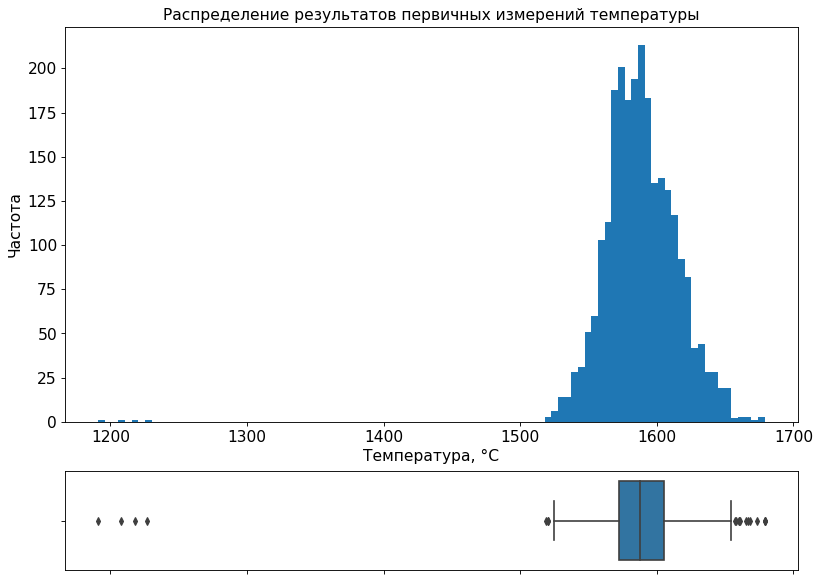

In [51]:
explore_distribution(
    data_final,
    'temp_in',
    'Распределение результатов первичных измерений температуры',
    'Температура, °С',
    'Частота',
    100,
    None
)

###### Вывод

Распределение значений выглядит нормальным. Наиболее часто температура расплава на входе в ковш находится в диапазоне от 1570 до 1600 °С. Имеется небольшое количество статистических выбросов ниже отметки в 1500 °С и выше отметки в 1650 °С.

Согласно литературным данным, в большинстве случаев температура плавления сталей колеблется в пределах от 1300 до 1500 °С, но, некоторые сплавы, например, медноникелевый, обладает температурой плавления 1150 °С. А так как нам неизвестен состав расплава в партиях, а также другие технологические факторы, решение об удалении объектов с начальной температурой расплава ниже 1300 °С примем после консультации с Заказчиком. 

Выбросы над верхней границей также не будем обрабатывать до консультации с Заказчиком.

По информации от заказчика входная температура < 1300 °С - действительно несвойственна расплаву. Выбросы выше верхней границы выглядят адекватно. Удалим из датасета объекты с входной температурой расплава < 1300 °С:

In [52]:
data_final = data_final[data_final['temp_in'] > 1300]

### Конечная температура расплава

Изучим данные столбца ***temp_out***:

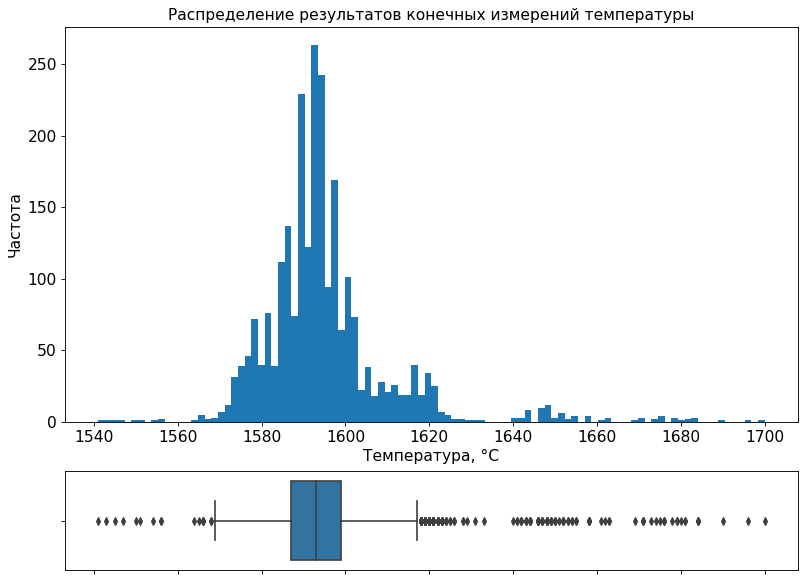

In [53]:
explore_distribution(
    data_final,
    'temp_out',
    'Распределение результатов конечных измерений температуры',
    'Температура, °С',
    'Частота',
    100,
    None
)

###### Вывод

Распределение значений выглядит нормальным. Чаще всего температура расплава на выходе из ковша находится в диапазоне от 1590 до 1600 °С. Имеются статистические выбросы ниже отметки в 1570 °С и выше отметки в 1615 °С.

Не будем обрабатывать обнаруженные выбросы: результаты измерений выглядят адекватно, находясь в пределах минимума и максимума данных ***temp_in***.

### Время на обработку расплава

Изучим данные столбца ***operating_time***:

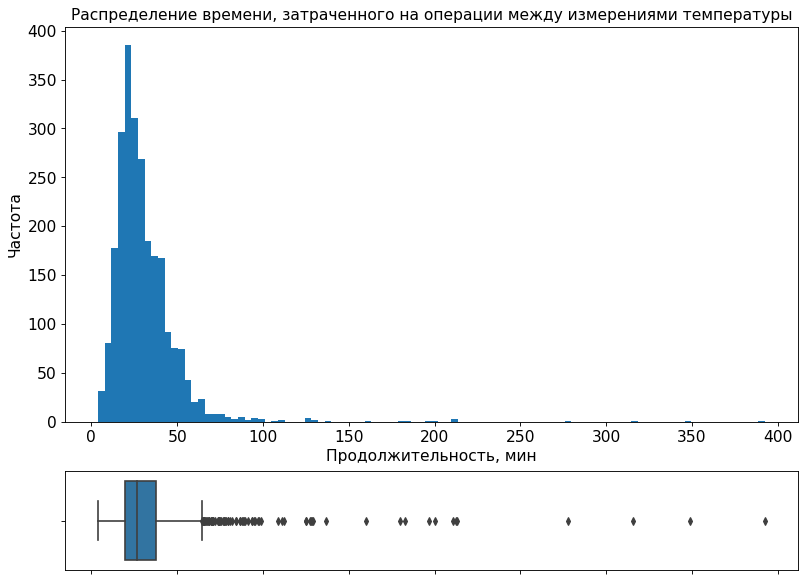

In [54]:
explore_distribution(
    data_final,
    'operating_time',
    'Распределение времени, затраченного на операции между измерениями температуры',
    'Продолжительность, мин',
    'Частота',
    100,
    None
)

###### Вывод

Распределение значений выглядит нормальным. Наиболее часто время между первым и последним измерениями температуры составляет от 20 до 30 минут. Имеются статистические выбросы выше отметки в 60 мин. При этом, действительно редкие значения встречаются при продолжительности обработки свыше 150 минут. Рассмотрим подробнее соответствующий срез датасета:

In [55]:
pd.set_option('display.max_columns', 50)
data_final[data_final['operating_time'] >150]

,temp_in,temp_out,operating_time,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44,1600.0,1603.0,179.55,2289.23,0.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,159.0,154.0,321.0,159.0,69.189123,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,21.265271
46,1607.0,1612.0,200.17,3119.40,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,401.0,204.0,100.245593,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,6.118441
118,1652.0,1600.0,159.97,1828.84,69.0,257.0,0.0,68.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,94.990898,0.000000,0.0,60.025684,0.000000,0.0,0.0,38.982740
638,1588.0,1619.0,213.15,2660.99,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.322388,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.798236
641,1617.0,1580.0,277.82,1862.51,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,208.0,153.0,0.0,156.0,221.176796,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,20.984894
801,1638.0,1582.0,212.55,1286.33,0.0,0.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,508.0,0.0,204.0,205.0,63.179999,36.403118,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,10.867395
1513,1553.0,1574.0,182.57,2018.67,0.0,0.0,200.0,0.0,0.0,220.0,0.0,0.0,0.0,0.0,21.0,157.0,0.0,180.0,103.0,130.197596,60.229519,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,38.471706
1689,1583.0,1606.0,392.28,8591.69,0.0,0.0,0.0,0.0,0.0,247.0,0.0,0.0,0.0,0.0,0.0,733.0,305.0,248.0,224.0,187.153206,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,33.597044
1880,1606.0,1615.0,196.98,3824.05,0.0,0.0,20.0,0.0,0.0,164.0,0.0,0.0,0.0,0.0,19.0,466.0,0.0,450.0,206.0,70.199997,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,26.379596


В партиях с длительным временем обработки наблюдается достаточно большое количество добавляемых материалов, высокая энергия, затраченная на нагрев, и длительная продувка инертным газом. Данные выглядят адекватно.

В связи с информацией выше, на данный момент необходимости удалять статистические выбросы нет.

### Энергия на нагрев расплава

Изучим данные столбца ***energy***:

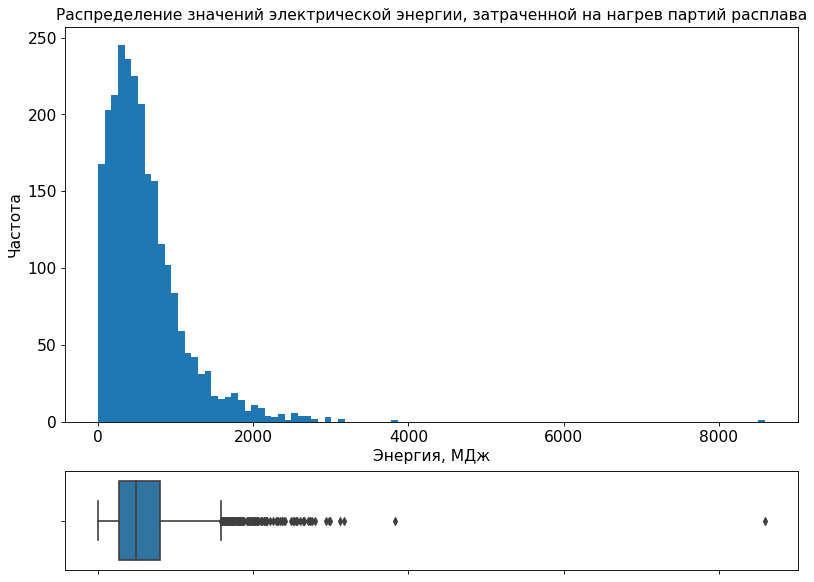

In [56]:
explore_distribution(
    data_final,
    'energy',
    'Распределение значений электрической энергии, затраченной на нагрев партий расплава',
    'Энергия, МДж',
    'Частота',
    100,
    None
)

###### Вывод

Распределение выглядит нормальным. Наиболее часто встречающиеся значения затраченной на нагрев энергии находятся в пределах от 400 до 600 МДж. Статистические выбросы наблюдаются выше отметки в 1500 МДж, но, как было выяснено ранее, высокая энергия, затраченная на нагрев, может быть связана с большим объемом добавляемых в расплав материалов, а также, предположительно, с более низкой начальной температурой расплава.

Данные выглядят адекватно. Нет необходимости обработки выбросов.

### Объем инертного газа

Изучим данные столбца ***gas***:

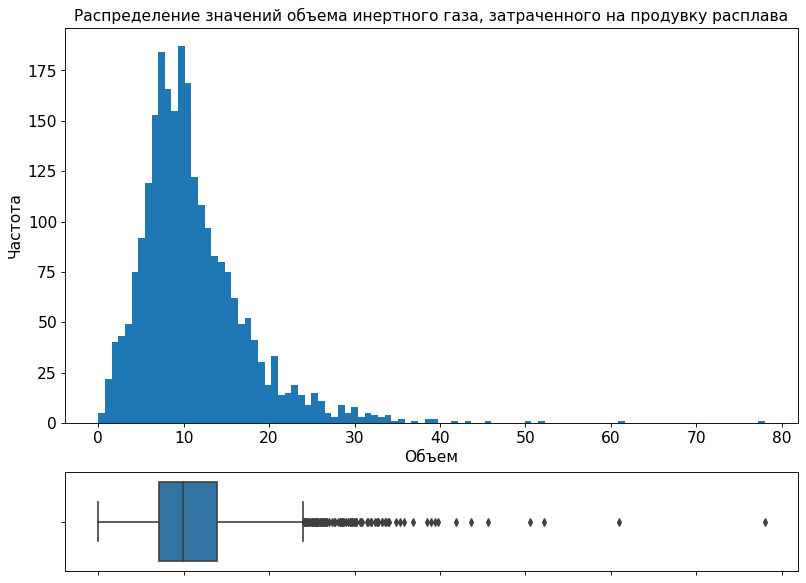

In [57]:
explore_distribution(
    data_final,
    'gas',
    'Распределение значений объема инертного газа, затраченного на продувку расплава',
    'Объем',
    'Частота',
    100,
    None
)

###### Вывод

Распределение выглядит нормальным. Чаще всего для продувки используется от 7 до 12 единиц объема газа. Статистические выбросы наблюдаются выше отметки в 25 единиц, но, как было выяснено ранее, это может быть связано с большим объемом добавляемых в расплав материалов.

Данные выглядят адекватно. Нет необходимости обработки выбросов.

### Масса сыпучих материалов

Напишем функцию для анализа сыпучих и проволочных материалов:

In [58]:
def analyze_additives(columns, title, xlabel, ylabel):
    print(
    '\n',
    ('\033[1m' + title + '\033[0m').center(125))

    axarr = data_final[columns].hist(figsize = (20,20), bins = 15, sharey = True)

    for ax in axarr.flatten():
        ax.set_xlabel('Масса')
        ax.set_ylabel('Частота')
    plt.show()

    data_final[columns].boxplot(figsize = (20,9))
    plt.title('Диаграмма размаха масс материалов')
    plt.xlabel('Вид материала')
    plt.ylabel('Масса')
    plt.show()

Изучим данные в столбцах ***bulk_1 - 15***:


                             Распределение массы сыпучих материалов, добавляемых в расплав                            


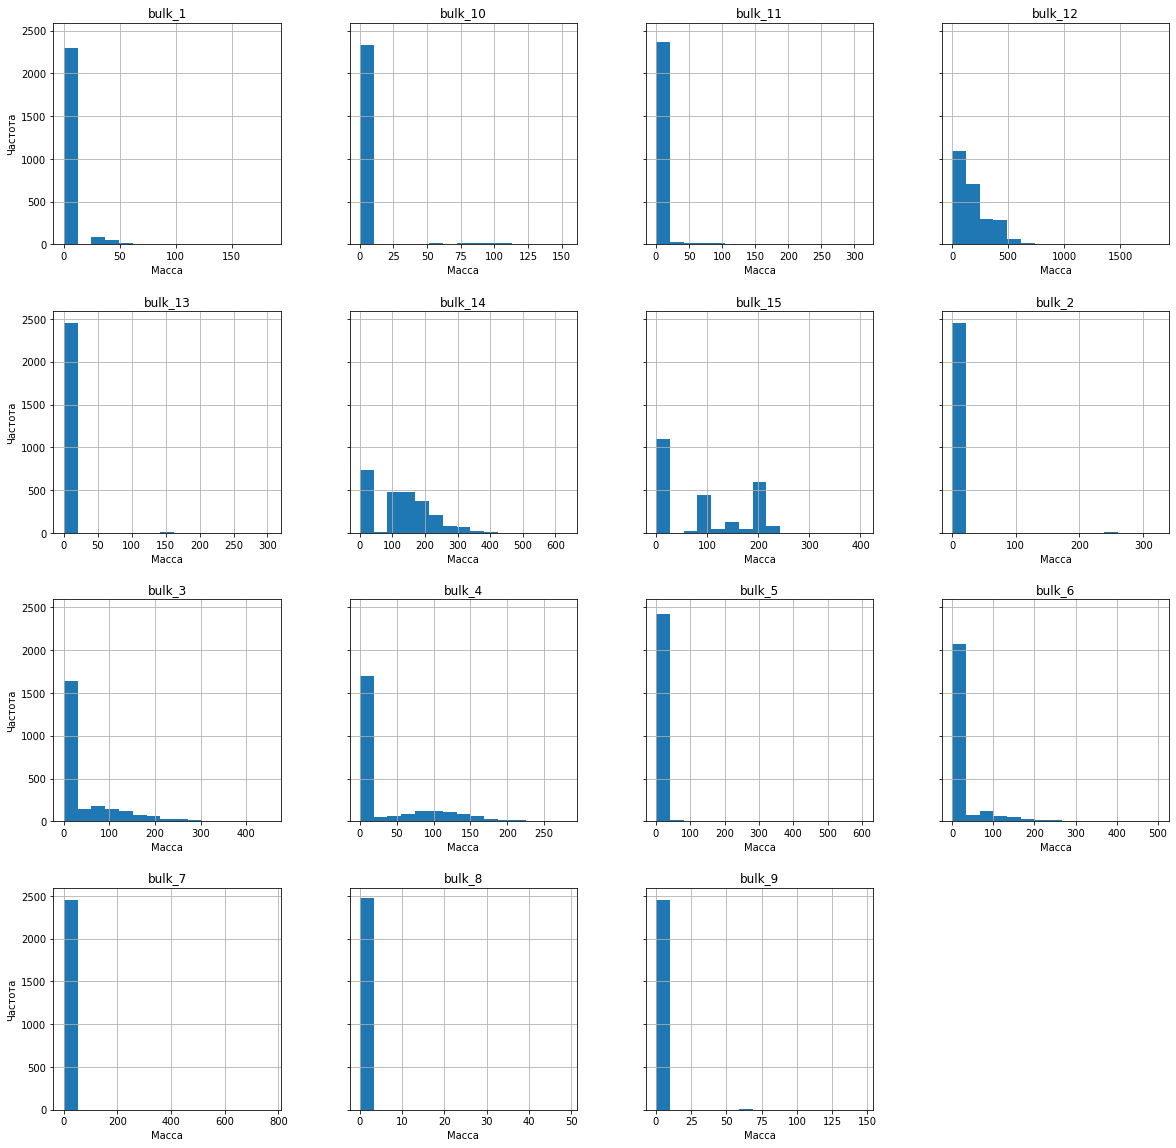

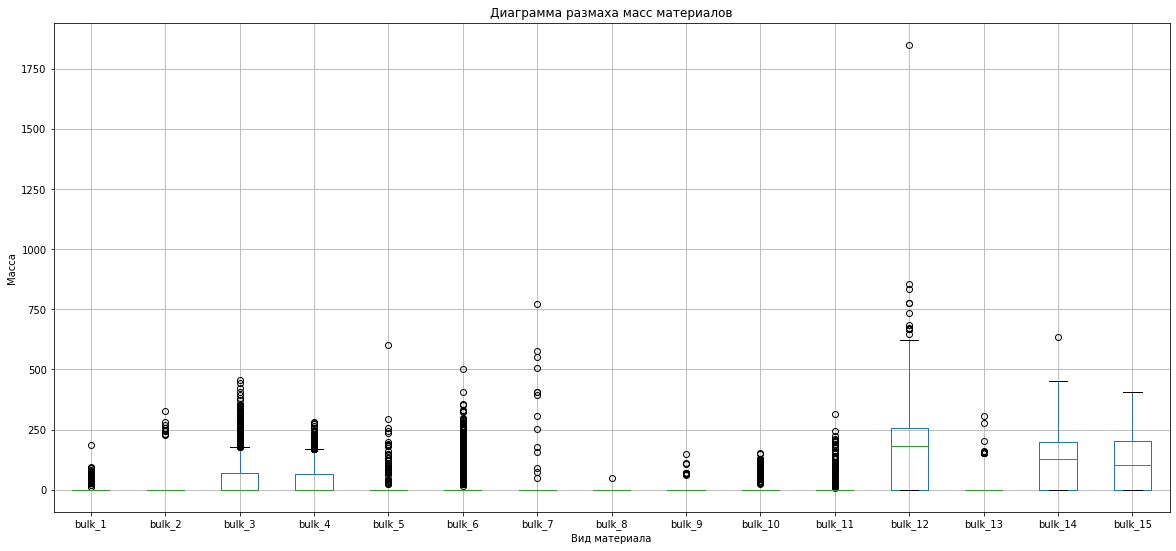

In [59]:
analyze_additives(
    data_bulk_final.columns,
    'Распределение массы сыпучих материалов, добавляемых в расплав',
    'Масса',
    'Частота')

Посмотрим, какие добавки из сыпучих материалов добавляются больше всего:

In [60]:
def top_5_additives(columns_names):
    df = data_final[columns_names].sum()\
    .sort_values(ascending = False).to_frame()
    df.columns = ['mass']
    return df.head()

In [61]:
top_5_additives(data_bulk_final.columns)

,mass
bulk_12,408332.0
bulk_14,301285.0
bulk_15,223181.0
bulk_3,105839.0
bulk_4,83273.0


###### Вывод

Гистограммы, построенные по данным загрузки сыпучих материалов в ковш с расплавом, иллюстрируют, в основном, Пуассоновское распределение значений. Видно, что для каждого вида сыпучего материала наиболее часто встречающееся значение в датасете - около нуля, что логично, учитывая тот факт, что материалы добавляются в расплав на основе химического анализа его состава, и носят непостоянный характер.


Наиболее популярными сыпучими добавками являются ***bulk_12,14,15***. Часть материалов добавляется в расплав крайне редко - вероятнее всего, они необходимы в эксклюзивных случаях, например, при приготовлении редких марок стали.

Диаграмма размаха масс сыпучих материалов демонстрирует наличие статистических выбросов в данных по каждому из видов материалов, но, в данном случае это не показатель аномальности: рассматриваемое производство может изменять технологические режимы, ориентируясь под технические задания на выпускаемую сталь, и, даже если требования к выпускаемой стали не изменяются - на производствах нередки сбои технологических режимов, которые, впоследствии, требуют определенной корректировки, например, на основе результатов физико-химических анализов. Все эти моменты не должны быть препятствием для работы модели машинного обучения - модель должна решать задачи на основе данных, максимально приближенных к реальным.

На основании вышенаписанного принимаем решение не обрабатывать статистические выбросы. Данные считаются адекватными.

### Масса проволочных материалов

Изучим данные в столбцах ***wire_1 - 9***:


                           Распределение массы проволочных материалов, добавляемых в расплав                          


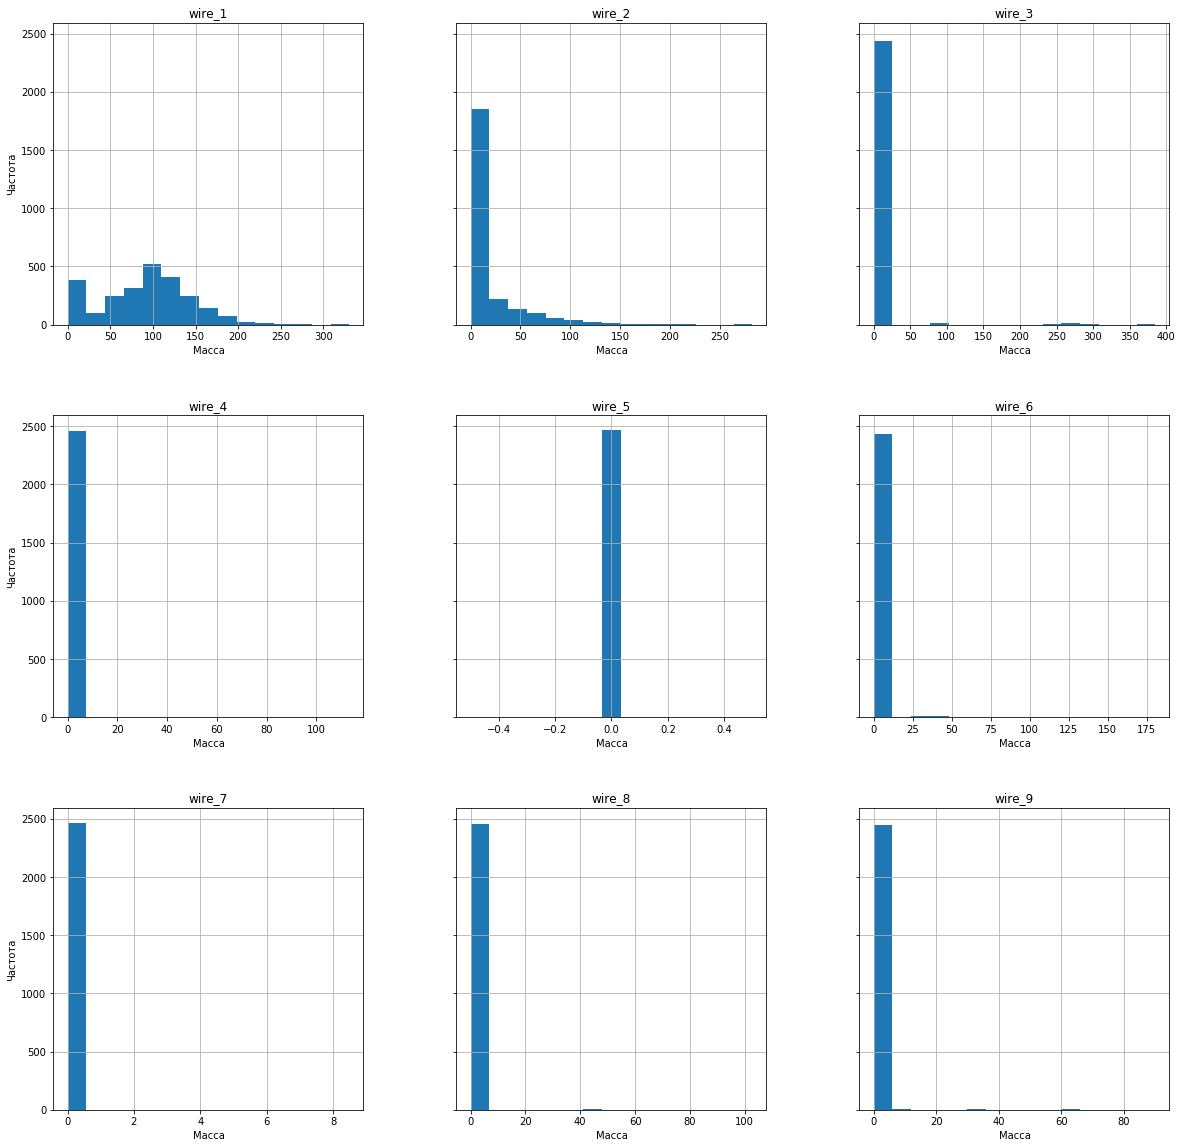

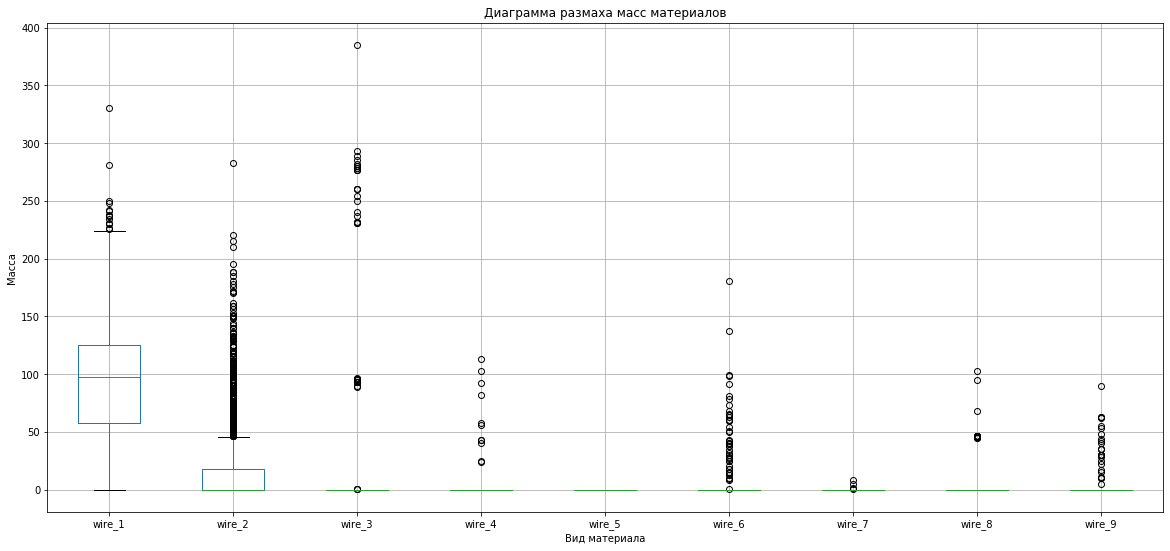

In [62]:
analyze_additives(
    data_wire_final.columns,
    'Распределение массы проволочных материалов, добавляемых в расплав',
    'Масса',
    'Частота')

Посмотрим, какие добавки из проволочных материалов добавляются больше всего:

In [63]:
top_5_additives(data_wire_final.columns)

,mass
wire_1,224270.795415
wire_2,39274.297743
wire_3,7289.650717
wire_6,2134.532544
wire_9,959.212811


###### Вывод

Гистограммы, построенные по данным загрузки проволочных материалов в ковш с расплавом, иллюстрируют, в основном, Пуассоновское распределение значений. Нормальное распределение имеют данные ***wire_1***, больше всего добавляемому в расплав проволочному материалу. В целом, для каждого вида проволочного материала наиболее часто встречающееся значение в датасете - около нуля, так как материалы добавляются в расплав на основе химического анализа его состава, и носят непостоянный характер.

Большая часть материалов добавляется в расплав крайне редко - вероятнее всего, они необходимы в строго определенных случаях, а ***wire_5*** не добавляется вообще - в дальнейшем следует удалить данный признак из датасета.

Диаграмма размаха масс проволочных материалов демонстрирует наличие статистических выбросов в данных по каждому из видов материалов, но, в данном случае это не показатель аномальности: рассматриваемое производство может изменять технологические режимы, ориентируясь под технические задания на выпускаемую сталь или корректируя работу после сбоев технологического процесса. Такие изменениея не должны искажать картину для обучения модели машинного обучения - модель должна решать задачи на основе данных, максимально приближенных к реальным.

На основании вышенаписанного принимаем решение не обрабатывать статистические выбросы. Данные считаются адекватными.

### Проверка данных на мультиколлинеарность

Для корректной работы моделей машинного обучения важно не допускать корреляции признаков между собой, поэтому необходимо проверить данные на мультиколлинеарность.

Так как в ходе анализа выше было обнаружено, что ***wire_5*** не добавлялся в расплав, по крайней мере между первой и последней итерациями измерений температуры, удалим данный столбец из датасета:

In [64]:
data_final.drop('wire_5', axis = 1, inplace = True)

Построим матрицу корреляции и выведем ТОП пар с самыми высоким коэффициентами корреляции:

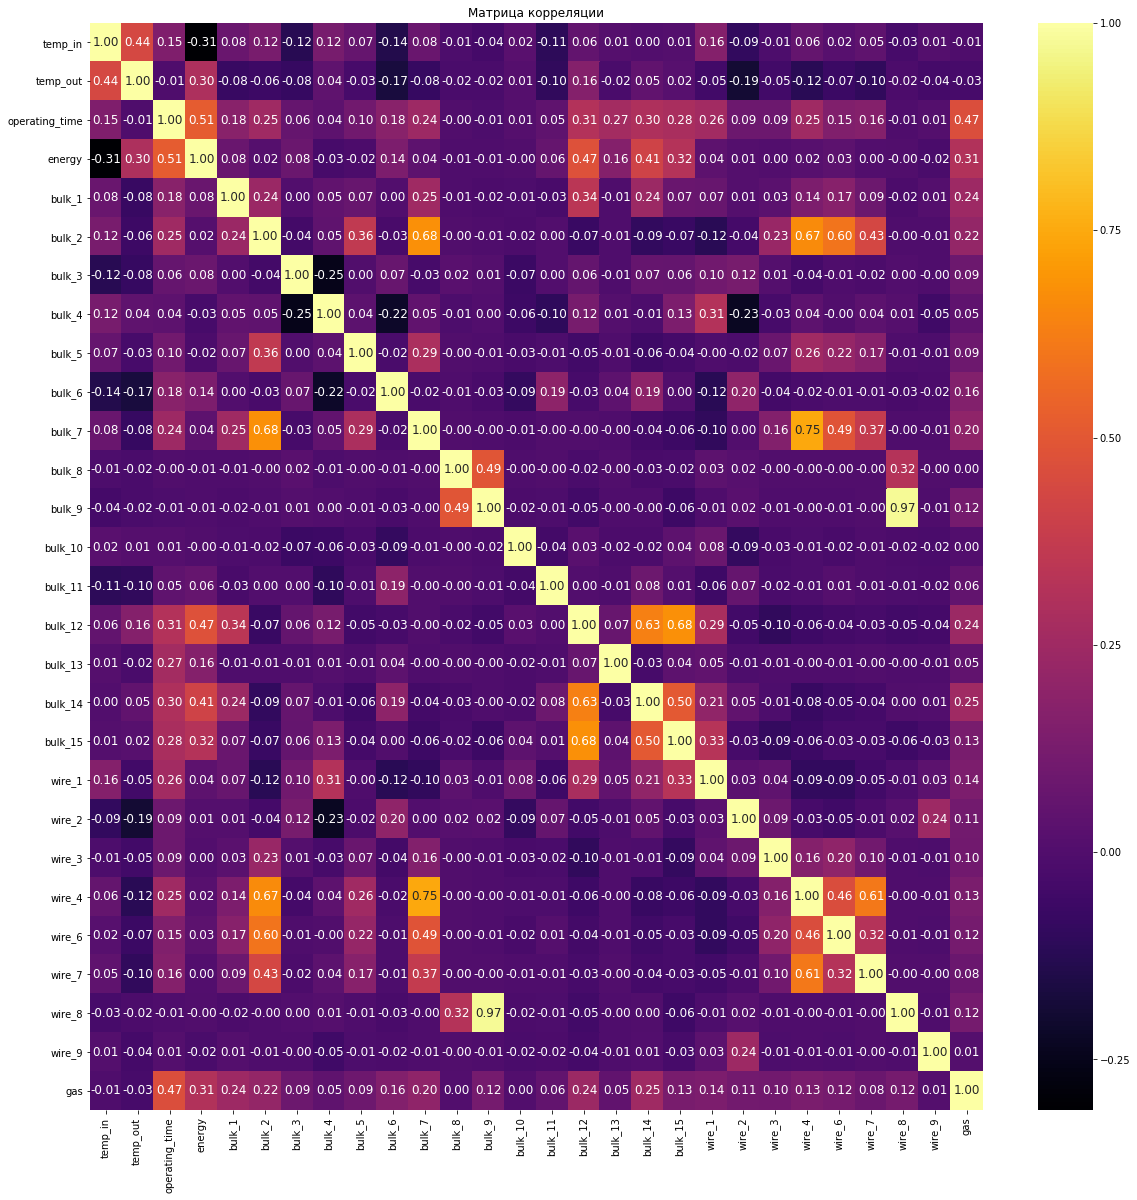

,,corr
wire_8,bulk_9,0.974976
bulk_7,wire_4,0.748159
bulk_2,bulk_7,0.679083
bulk_12,bulk_15,0.678357
bulk_2,wire_4,0.666172
bulk_14,bulk_12,0.634880
wire_4,wire_7,0.609366
bulk_2,wire_6,0.595899
energy,operating_time,0.514919
bulk_14,bulk_15,0.504314


In [65]:
ax = plt.figure(figsize=(20, 20))
plt.title('Матрица корреляции')
sns.heatmap(data_final.corr(), annot=True, cmap="inferno", fmt='.2f', annot_kws={'size':12})
plt.show()

top_corr = data_final.corr().unstack().sort_values(ascending = False).to_frame()
top_corr.columns = ['corr']
top_corr = top_corr[top_corr['corr']<1].drop_duplicates()
top_corr.head(10)

###### Вывод

В таблице выше отражен ТОП-10 наиболее сильно коррелирующих пар признаков. Наибольшие коэффициенты корреляции имеют комбинации сыпучих и проволочных добавок, что говорит о том, что с большей долей вероятностью данные добавки добавляются в расплав в паре. 

На этапе подготовки признаков необходимо учесть наличие сильно коррелирующих пар и удалить лишние данные из датасета.

## Разработка модели

### Подготовка признаков

#### Формирование обучающей и тестовой выборок

Целевым признаком в данной задаче является конечная температура расплава перед его дальнейшим розливом. Целевой признак хранится в столбце ***temp_out*** в датасете ***data_final***.

Отделим целевой от остальных признаков:

In [66]:
features = data_final.drop('temp_out', axis = 1)
target = data_final['temp_out']

Сформируем обучающую и тестовую выборки. Размер тестовой выборки зададим равным 25% от размера исходных данных: 

In [67]:
features_train,features_test,target_train,target_test = train_test_split(
    features,
    target,
    test_size = 0.25,
    random_state = 12345)

Проверим результат разделения:

In [68]:
print('Размер обучающей таблицы признаков:',features_train.shape,'\n'
      'Размер обучающей таблицы с целевым признаком:',target_train.shape,'\n'
      '% обучающей выборки от исходных данных:',np.round(
          len(target_train)/(len(target_train) + len(target_test))*100,0),'\n',
      
      
      '\n' + 'Размер тестовой таблицы признаков:',features_test.shape,'\n'
      'Размер тестовой таблицы с целевым признаком:',target_test.shape,'\n'
      '% тестовой выборки от исходных данных:',np.round(
          len(target_test)/(len(target_train) + len(target_test))*100,0)
     )

Размер обучающей таблицы признаков: (1853, 27) 
Размер обучающей таблицы с целевым признаком: (1853,) 
% обучающей выборки от исходных данных: 75.0 
 
Размер тестовой таблицы признаков: (618, 27) 
Размер тестовой таблицы с целевым признаком: (618,) 
% тестовой выборки от исходных данных: 25.0


Обучающая и тестовая выборки сформированы корректно.

In [69]:
data_final

,temp_in,temp_out,operating_time,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,14.35,708.20,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,21.75,673.81,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,21.67,146.21,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,6.47,339.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,12.70,691.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,18.95,445.04,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2496,1554.0,1591.0,26.97,681.82,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2497,1571.0,1589.0,11.95,336.90,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699


#### Масштабирование признаков

При разном масштабе признаков алгоритмы обучения могут сильнее выделять те или иные признаки. Для того, чтобы алгоритм воспринимал значимость каждого из признаков одинаково, стандартизируем признаки:

In [70]:
scaler = StandardScaler()
scaler.fit(features_train)

pd.options.mode.chained_assignment = None

features_train = pd.DataFrame(scaler.transform(features_train), columns = features.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns = features.columns)

Проверим результат:

In [71]:
display(features_train.describe())
display(features_test.describe())

,temp_in,operating_time,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
count,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03,1.853000e+03
mean,-3.736772e-15,-5.751830e-17,-2.645842e-16,-2.492460e-17,3.451098e-17,-5.320443e-17,-1.725549e-17,1.342094e-17,2.875915e-17,-2.875915e-17,5.751830e-18,1.917277e-17,7.669107e-18,-3.259370e-17,4.601464e-17,4.409736e-17,-8.052562e-17,-1.150366e-17,3.930417e-17,5.751830e-18,-2.684187e-17,8.627745e-18,1.342094e-17,-1.917277e-18,-1.533821e-17,-9.586383e-18,-5.224579e-17
std,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00
min,-2.817038e+00,-1.208000e+00,-1.156465e+00,-2.639945e-01,-7.324453e-02,-5.933049e-01,-5.880950e-01,-1.147448e-01,-3.788805e-01,-6.208027e-02,-2.323697e-02,-7.353328e-02,-2.204520e-01,-1.822857e-01,-1.008584e+00,-7.118912e-02,-1.277239e+00,-1.024762e+00,-1.723140e+00,-4.988306e-01,-1.120921e-01,-6.446738e-02,-1.150533e-01,-2.655097e-02,-7.274270e-02,-1.016727e-01,-1.745458e+00
25%,-6.914791e-01,-5.050697e-01,-6.592941e-01,-2.639945e-01,-7.324453e-02,-5.933049e-01,-5.880950e-01,-1.147448e-01,-3.788805e-01,-6.208027e-02,-2.323697e-02,-7.353328e-02,-2.204520e-01,-1.822857e-01,-1.008584e+00,-7.118912e-02,-1.277239e+00,-1.024762e+00,-6.189160e-01,-4.988306e-01,-1.120921e-01,-6.446738e-02,-1.150533e-01,-2.655097e-02,-7.274270e-02,-1.016727e-01,-6.392496e-01
50%,-4.980104e-02,-1.930976e-01,-2.295093e-01,-2.639945e-01,-7.324453e-02,-5.933049e-01,-5.880950e-01,-1.147448e-01,-3.788805e-01,-6.208027e-02,-2.323697e-02,-7.353328e-02,-2.204520e-01,-1.822857e-01,1.063734e-01,-7.118912e-02,5.823791e-02,1.326282e-01,1.213415e-01,-4.988306e-01,-1.120921e-01,-6.446738e-02,-1.150533e-01,-2.655097e-02,-7.274270e-02,-1.016727e-01,-2.069226e-01
75%,6.319819e-01,2.958204e-01,3.596800e-01,-2.639945e-01,-7.324453e-02,3.886550e-01,5.567379e-01,-1.147448e-01,-3.788805e-01,-6.208027e-02,-2.323697e-02,-7.353328e-02,-2.204520e-01,-1.822857e-01,5.511378e-01,-7.118912e-02,7.829155e-01,1.245072e+00,6.307306e-01,1.022067e-01,-1.120921e-01,-6.446738e-02,-1.150533e-01,-2.655097e-02,-7.274270e-02,-1.016727e-01,4.275883e-01
max,3.599743e+00,1.592972e+01,1.514775e+01,7.942876e+00,1.706338e+01,5.685706e+00,4.361106e+00,2.525852e+01,8.811225e+00,2.405710e+01,4.303487e+01,2.218180e+01,7.846824e+00,1.378755e+01,4.188458e+00,2.303829e+01,3.381402e+00,3.526142e+00,4.489882e+00,8.375698e+00,1.394316e+01,2.262754e+01,1.418094e+01,4.269109e+01,2.177958e+01,1.467075e+01,7.747653e+00


,temp_in,operating_time,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
count,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,6.180000e+02,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000
mean,-0.036692,-0.063953,-0.028705,-0.042477,-0.010193,-0.003655,0.021827,-0.044274,-0.077061,-0.009807,-2.323697e-02,-0.040216,0.060714,-0.053878,-0.007090,0.001024,-0.059861,-0.039397,-0.063877,-0.000097,-0.017575,-0.015159,0.037634,0.014446,-0.041371,-0.042838,-0.041906
std,1.010651,0.815348,0.847063,1.059783,0.904241,1.011851,0.987294,0.589437,0.803316,0.682979,3.472257e-18,0.585758,1.111427,0.796408,1.048945,1.078835,0.989315,1.001281,1.009301,1.047885,0.894351,1.027197,1.489869,1.019163,0.551047,0.952850,0.944265
min,-2.496199,-1.186819,-1.156465,-0.263995,-0.073245,-0.593305,-0.588095,-0.114745,-0.378881,-0.062080,-2.323697e-02,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,-1.723140,-0.498831,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-1.745458
25%,-0.721558,-0.530773,-0.598663,-0.263995,-0.073245,-0.593305,-0.588095,-0.114745,-0.378881,-0.062080,-2.323697e-02,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,-0.686287,-0.498831,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-0.640844
50%,-0.130011,-0.255316,-0.195370,-0.263995,-0.073245,-0.593305,-0.588095,-0.114745,-0.378881,-0.062080,-2.323697e-02,-0.073533,-0.220452,-0.182286,0.066771,-0.071189,0.011651,0.121391,0.046840,-0.498831,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-0.171882
75%,0.631982,0.224667,0.339811,-0.263995,-0.073245,0.357537,0.697640,-0.114745,-0.378881,-0.062080,-2.323697e-02,-0.073533,-0.220452,-0.182286,0.545045,-0.071189,0.769975,1.233835,0.630511,0.008012,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,0.398187
max,3.599743,7.998927,3.983019,15.887825,13.477875,5.561233,4.079301,7.627677,4.992672,12.622359,-2.323697e-02,10.675643,7.480130,7.672958,10.256751,20.992532,5.306974,3.526142,2.943521,6.416411,10.101777,24.873106,25.885759,25.309431,9.729290,20.999352,10.405312


Данные успешно стандартизированы.

In [72]:
features_train

,temp_in,operating_time,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
0,0.431458,-0.535075,-0.848245,-0.263995,-0.073245,-0.330527,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,-0.648317,1.489798,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-1.113030
1,-2.055045,0.030622,0.185569,-0.263995,-0.073245,1.149328,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,4.075110,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,0.881317,-0.498831,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,1.813261
2,-0.330535,-1.069002,-1.063764,-0.263995,-0.073245,-0.593305,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,-0.444972,-0.498831,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-0.819854
3,-0.330535,-0.291499,0.030908,-0.263995,-0.073245,-0.593305,0.785705,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,0.240412,-0.071189,0.058238,0.121391,-0.065572,-0.498831,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-0.759610
4,0.110618,0.816068,0.186536,-0.263995,-0.073245,-0.593305,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,0.240412,-0.071189,0.772563,0.716942,0.159780,2.602901,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,2.252362,2.195417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,-0.731584,-0.595970,0.013431,-0.263995,-0.073245,0.623772,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,0.246505,-0.071189,-0.138460,0.200049,0.159957,1.232346,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-0.233509
1849,0.832506,-0.888967,-1.156465,-0.263995,-0.073245,-0.593305,0.997058,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,0.160661,-0.023680,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-1.344349
1850,-0.892003,-0.389459,-0.095116,-0.263995,-0.073245,0.554620,0.098805,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,-0.098142,-0.024626,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-0.537738
1851,-1.172738,0.400399,-0.083806,-0.263995,-0.073245,3.777108,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,0.563323,-0.071189,0.037533,1.525992,1.459720,-0.498831,-0.112092,-0.064467,-0.115053,-0.026551,-0.072743,-0.101673,-1.203459


#### Устранение коллинеарности признаков

Напишем функцию для нахождения и удаления коллинеарных признаков:

In [73]:
def remove_collinear_features(train, test, threshold):
    
    corr_matrix = features.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            if val >= threshold:
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    train = train.drop(columns=drops)
    test = test[train.columns]

    return train, test

Перед обучением моделей проверим обучающую выборку на наличие коллинеарных признаков, устраним коллинеарность пар с коэффициентом корреляции ***>= 0.7*** и пересохраним обучающую и тестовую выборки:

In [74]:
features_train, features_test = remove_collinear_features(features_train,features_test, 0.7)

wire_4 | bulk_7 | 0.75
wire_8 | bulk_9 | 0.97


Проверим результат:

In [75]:
display(features_train.head(3))
display(features_test.head(3))

,temp_in,operating_time,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_7,wire_9,gas
0,0.431458,-0.535075,-0.848245,-0.263995,-0.073245,-0.330527,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,-0.648317,1.489798,-0.112092,-0.115053,-0.026551,-0.101673,-1.113030
1,-2.055045,0.030622,0.185569,-0.263995,-0.073245,1.149328,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,4.075110,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,0.881317,-0.498831,-0.112092,-0.115053,-0.026551,-0.101673,1.813261
2,-0.330535,-1.069002,-1.063764,-0.263995,-0.073245,-0.593305,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,-0.444972,-0.498831,-0.112092,-0.115053,-0.026551,-0.101673,-0.819854


,temp_in,operating_time,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_7,wire_9,gas
0,-0.731584,-0.579202,-0.332932,-0.263995,-0.073245,-0.593305,4.079301,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,-0.551486,-0.498831,-0.112092,-0.115053,-0.026551,-0.101673,0.351115
1,0.591877,0.598967,-0.290538,-0.263995,-0.073245,-0.593305,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,0.240412,-0.071189,0.223879,0.121391,-0.102543,1.547536,-0.112092,-0.115053,-0.026551,-0.101673,0.902945
2,-0.851899,-0.498451,-0.111436,-0.263995,-0.073245,1.052515,-0.588095,-0.114745,-0.378881,-0.06208,-0.023237,-0.073533,-0.220452,-0.182286,-1.008584,-0.071189,-1.277239,-1.024762,0.349041,-0.498831,-0.112092,-0.115053,-0.026551,-0.101673,-0.540874


Преобразование обучающей и тестовой выборок успешно. Из выборок удалены признаки ***wire_4*** и ***wire_8***.

### Обучение моделей

Целевой метрикой в данной задаче является средняя абсолютная ошибка, ***MAE*** ( *Mean Absolute Error* ). Подберем модель, позволяющую добиться минимального значения метрики, с помощью ***GridSearchCV***.

Напишем функцию для подбора наилучших параметров модели:

In [76]:
def get_best_params(model,parameters):
    grid = GridSearchCV(
    model,
    parameters,    
    scoring = 'neg_mean_absolute_error'
    )
    
    grid.fit(features_train,target_train)
    
    greed_result = pd.DataFrame(
        grid.cv_results_).sort_values(
        by = 'rank_test_score').reset_index(
        drop = True)
    
    display(greed_result[greed_result['rank_test_score']==1])

#### Dummy Regressor

Для проверки обучаемых далее моделей на адекватность получим ***MAE*** при предсказании ***Dummy Regressor***'ом только среднего значения целевого признака:

In [77]:
dummy = DummyRegressor()

In [78]:
get_best_params(
    dummy,
    {
        'strategy':['mean']
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000452,0.000142,0.000154,0.000021,mean,{'strategy': 'mean'},-9.977847,-10.510181,-10.03531,-10.02486,-10.145184,-10.138677,0.193682,1


***Dummy Regressor*** предсказывает целевой признак с ошибкой ***MAE = 10.14***.

#### Дерево решений

Рассмотрим модель ***Дерево решений***:

In [79]:
decision_tree = DecisionTreeRegressor()

In [80]:
get_best_params(
    decision_tree,
    {
        'max_depth':range(1,21,1),
        'random_state':[12345]
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00612,0.000048,0.000888,0.000054,7,12345,"{'max_depth': 7, 'random_state': 12345}",-7.011347,-7.169754,-7.721383,-7.599765,-7.543982,-7.409246,0.271131,1


Наилучшее значение метрики, ***MAE = 7.41***, получено при следующих параметрах:
 - ***semax_depth*** = ***7***;
 - ***random_seed*** = ***12345***

Модель адекватна, так как полученное значение метрики лучше, чем у ***Dummy-модели***.

#### Случайный лес

Рассмотрим модель ***Случайный лес***:

In [81]:
random_forest = RandomForestRegressor()

In [82]:
get_best_params(
    random_forest,
    {
        'max_depth':range(15,18,1),
        'n_estimators': range(91,102,1),       
        'random_state':[12345]
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.592558,0.003737,0.008272,0.000168,15,100,12345,"{'max_depth': 15, 'n_estimators': 100, 'random...",-5.853146,-5.702461,-6.385713,-6.483405,-6.597397,-6.204425,0.357907,1


Наилучшее значение метрики, ***MAE = 6.20***, получено при следующих параметрах:
 - ***max_debth*** = ***15***;
 - ***n_estimators*** = ***100***;
 - ***random_state*** = ***12345***.
 
Модель адекватна, так как полученное значение метрики лучше, чем у ***Dummy-модели***.

#### Линейная регрессия

Рассмотрим модель ***Линейная регрессия***:

In [83]:
linear_regression = LinearRegression()

In [84]:
get_best_params(linear_regression, {'n_jobs': [None]})

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005958,0.000358,0.001002,0.000062,None,{'n_jobs': None},-7.016592,-7.076955,-7.043691,-7.550434,-8.046668,-7.346868,0.401251,1


В результате применения линейной регрессии полученное значение ***MAE = 7.35***. Модель адекватна, так как полученное значение метрики лучше, чем у ***Dummy-модели***.

#### XGBoost Regressor

In [85]:
xgbr = xgb.XGBRegressor()

In [86]:
warnings.simplefilter(action='ignore', category=UserWarning)

get_best_params(
    xgbr,
    {
     'max_depth': range(1,11),
     'n_estimators': range(81,102,1),
     'learning_rate':[0.1],
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.104833,0.005154,0.001282,0.000011,0.1,5,96,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-5.596963,-5.612247,-6.170151,-6.028826,-6.325788,-5.946795,0.294807,1


Наилучшее значение метрики, ***MAE = 5.95*** получено при следующих гиперпараметрах:
 - ***max_debth*** = ***5***;
 - ***n_estimators*** = ***96***;
 - ***learning_rate*** = ***0.1***.
 
Модель адекватна, так как полученное значение метрики лучше, чем у ***Dummy-модели***.

#### LightGMB Regressor

Рассмотрим модель ***LGBMRegressor***

In [87]:
lgbr = lgb.LGBMRegressor()

In [88]:
get_best_params(
    lgbr,
    {
        'learning_rate':np.arange(0.15,0.21,0.01),
        'max_depth':range(1,11,1),
        'n_estimators':range(65,72,1)
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01815,0.000713,0.001153,0.000034,0.15,4,66,"{'learning_rate': 0.15, 'max_depth': 4, 'n_est...",-5.621021,-5.733595,-6.062343,-6.379193,-6.333734,-6.025977,0.306684,1


Наилучшее значение метрики, ***MAE = 6.03*** получено при следующих гиперпараметрах:
 - ***learning_rate*** = ***0.15***;
 - ***max_depth*** = ***4***;
 - ***n_estimators*** = ***66***.
 
Модель адекватна, так как полученное значение метрики лучше, чем у ***Dummy-модели***.

#### CatBoost Regressor

Рассмотрим модель ***CatBoostRegressor***:

In [89]:
cbr = cb.CatBoostRegressor()

In [90]:
get_best_params(
    cbr,
    {'silent':[True],
     'iterations':range(435,441,1),
     'learning_rate':[0.06]
    }
)    

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_iterations,param_learning_rate,param_silent,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.523536,0.003567,0.002292,0.000197,437,0.06,True,"{'iterations': 437, 'learning_rate': 0.06, 'si...",-5.574716,-5.54227,-6.104995,-6.194164,-6.1478,-5.912789,0.290834,1


Наилучшее значение метрики, ***MAE = 5.91*** получено при следующих гиперпараметрах:
 - ***iterations*** = ***437***;
 - ***learning_rate*** = ***0.06***.
 
Модель адекватна, так как полученное значение метрики лучше, чем у ***Dummy-модели***.

###### Вывод

На данном этапе были рассмотрены следующие модели, потенциально позволяющие решить поставленную проектом задачу:

 - ***Дерево решений***;
 - ***Случайный лес***;
 - ***Линейная регрессия***;
 - ***XGBoost Regressor***;
 - ***LightGBM Regressor***;
 - ***CatBoost Regressor***.
 
К каждой модели были подобраны гиперпараметры с помощью ***GridsearchCV*** для получения наилучшего значения ***MAE***.
 
В результате выделен ТОП-3 моделей с лучшим значением ***RMSE***:
 
  1. ***CatBoost Regressor*** ( MAE = 5.91 );
  2. ***XGBoost Regressor*** ( MAE = 5.95 );
  2. ***LightGBM Regressor*** ( MAE = 6.03 ).
  
Весь ТОП-3 заняли модели, использующие бустинг. ***MAE*** всех перечисленных моделей < ***MAE Dummy-модели ( 10.14 )***
  
Далее исследуем время обучения и предсказания конечной температуры расплава, а также ***MAE*** на тестовой выборке каждой модели из ТОП-3.

## Тестирование моделей

### XGBoost Regressor

Обучим модель ***XGBoost Regressor*** с заданием подобранных на предыдущем этапе гиперпараметров и рассчитаем время обучения:

In [91]:
%%time

xgbr = xgb.XGBRegressor(
    max_depth = 5,
    n_estimators = 96,
    learning_rate = 0.1  
)

xgbr.fit(features_train, target_train)

CPU times: user 869 ms, sys: 128 ms, total: 996 ms
Wall time: 139 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=96, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Время обучения ***XGBoost Regressor*** = 792 милисекунды.

Рассчитаем время предсказания моделью целевого признака:

In [92]:
%%time
xgbr_predictions = xgbr.predict(features_test)

CPU times: user 7.63 ms, sys: 3.97 ms, total: 11.6 ms
Wall time: 1.97 ms


Время предсказания ***XGBoost Regressor*** = 15.7 милисекунд.

Рассчитаем ***MAE*** модели на тестовой выборке:

In [93]:
mae_xgbr = mean_absolute_error(target_test, xgbr_predictions)
print('MAE модели на тестовой выборке: ', mae_xgbr.round(2))

MAE модели на тестовой выборке:  6.09


### LightGBM Regressor

Обучим модель ***LightGBM Regressor*** с заданием подобранных на предыдущем этапе гиперпараметров и рассчитаем время обучения:

In [94]:
%%time

lgbr = lgb.LGBMRegressor(
    learning_rate = 0.15,
    max_depth = 4,
    n_estimators = 66
)

lgbr.fit(features_train, target_train)

CPU times: user 211 ms, sys: 45.4 ms, total: 257 ms
Wall time: 42.5 ms


LGBMRegressor(learning_rate=0.15, max_depth=4, n_estimators=66)

Время обучения ***LightGBM Regressor*** = 435 милисекунд.

Рассчитаем время предсказания моделью целевого признака:

In [95]:
%%time
lgbr_predictions = lgbr.predict(features_test)

CPU times: user 9.61 ms, sys: 4.76 ms, total: 14.4 ms
Wall time: 2.38 ms


Время предсказаний ***LightGBM Regressor*** = 12.6 милисекунд.

Рассчитаем ***MAE*** модели на тестовой выборке:

In [96]:
mae_lgbr = mean_absolute_error(target_test, lgbr_predictions)
print('MAE модели на тестовой выборке: ', mae_lgbr.round(2))

MAE модели на тестовой выборке:  6.22


### CatBoost Regressor

Обучим модель ***CatBoost Regressor*** с заданием подобранных на предыдущем этапе гиперпараметров и рассчитаем время обучения:

In [97]:
%%time

cbr = cb.CatBoostRegressor(
    silent = True,
    iterations = 437,
    learning_rate = 0.06
)

cbr.fit(features_train, target_train)

CPU times: user 1.79 s, sys: 755 ms, total: 2.54 s
Wall time: 576 ms


Время обучения ***CatBoost Regressor*** = 2.01 секунда.

Рассчитаем время предсказания моделью целевого признака:

In [98]:
%%time
cbr_predictions = cbr.predict(features_test)

CPU times: user 2.57 ms, sys: 1.02 ms, total: 3.59 ms
Wall time: 2.34 ms


Время предсказания ***CatBoost Regressor*** = 10.6 милисекунд.

Рассчитаем ***MAE*** модели на тестовой выборке:

In [99]:
mae_сbr = mean_absolute_error(target_test, cbr_predictions)
print('MAE модели на тестовой выборке: ', mae_сbr.round(2))

MAE модели на тестовой выборке:  5.75


###### Вывод

Сформируем итоговую таблицу:

In [100]:
results = pd.DataFrame(
    {
        'Модель':['XGBoost Regressor', 'LightGBM Regressor','CatBoost Regressor'],
        'MAE':[6.09, 6.22, 5.75],
        'Время обучения, сек': [0.767, 0.996, 2.54],
        'Время предсказаний, сек': [0.012, 0.012, 3.59]
    }
)

results.sort_values(
    by = 'MAE',
    ascending = True).set_index(
    pd.Index([1, 2, 3]))

,Модель,MAE,"Время обучения, сек","Время предсказаний, сек"
1,CatBoost Regressor,5.75,2.540,3.590
2,XGBoost Regressor,6.09,0.767,0.012
3,LightGBM Regressor,6.22,0.996,0.012


На тестовой выборке по показателю ***MAE***  порядок моделей в ТОП-3 не изменился. Наилучшая метрика качества - у модели ***CatBoost Regressor***. Но данная модель демонстрирует наибольшее время обучения и предсказаний.

Наименьшее время обучения и предсказаний демонстрирует модель ***XGBoost Regressor*** при этом обладая вторым результатом по показателю ***MAE***.

Так как основным требованием Заказчика к модели является минимальное значение ***MAE*** ( предпочтительно ≤ 6.0 ), рекомендуется запуск в производство модели ***CatBoost Regressor***.

### Проверка результатов на случайность

При тестировании моделей наивысшую метрику качества показала модель ***CatBoost Regressor*** со следующими гиперпараметрами:

 - ***iterations*** = ***437***;
 - ***learning_rate*** = ***0.06***.
 
Полученное значение ***MAE*** модели на тестовой выборки = 5.75 °С, что удовлетворяет требования Заказчика по значению метрики качества.

Для того, чтобы убедиться, что значение данной метрики не является случайным результатом, полученным благодаря удачному разбиению исходных данных на обучающую и тестовую выборки, применим для проверки технику ***Bootstrap***.

Алгоритм проверки заключается в следующем: тестовая выборка будет сформирована заново 1000 раз из случайных объектов, выбранных из первоначальной тестовой выборки. При этом, один и тот же объект может быть выбран несколько раз. В каждой из 1000 сформированных выборок обученная ранее модель ***CatBoost Regressor*** предскажет целевой признак. На основании предсказаний и истинных значений целевого признака на каждой итерации цикла будет рассчитано значение ***MAE*** и записано в переменную ***mae_cbr_bootstrap***. Конечным результатом проверки будет являться среднее значение ***MAE*** из ***mae_cbr_bootstrap***.

Осуществим проверку:

In [101]:
mae_сbr_bootstrap = []

for i in range(1000):
    
    features_test_bootstrap = features_test.sample(n=len(features_test),replace = True)
    target_test_bootstrap = target_test.reset_index(drop=True)[features_test_bootstrap.index]
    cbr_predictions_bootstrap = cbr.predict(features_test_bootstrap)
    mae_сbr_bootstrap.append(mean_absolute_error(target_test_bootstrap, cbr_predictions_bootstrap))
    
print(
    'Среднее значение MAE из 1000 предсказаний тестового целевого признака:',
    np.round(pd.Series(mae_сbr_bootstrap).mean(),2)
)

Среднее значение MAE из 1000 предсказаний тестового целевого признака: 5.74


###### Вывод

Среднее ***MAE*** переменной ***mae_сbr_bootstrap*** ( 5.74 ) < ***MAE*** на тестовой выборке ( 5.75 ).

Проверка на случайность пройдена.

### Исследование значимости признаков

Исследуем значимость признаков для ***CatBoost Regressor***:

In [102]:
cbr_feature_importance = pd.DataFrame(
    cbr.get_feature_importance(prettified=True)
    ).set_index('Feature Id')

In [103]:
def build_pareto(
    data,
    column,
    title,
    xlabel,
    ylabel_primary,
    ylabel_secondary):
    
    data['cumpercentage'] = data[column].cumsum()/data[column].sum()*100
    fig, ax = plt.subplots(figsize = (16,9))
    ax.bar(data.index, data[column], color='C0')
    ax2 = ax.twinx()
    ax2.plot(data.index, data['cumpercentage'], color='red', marker='D', ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    
    ax.tick_params(axis='x', labelrotation = 90)

    ax.tick_params(axis='y', colors="C0")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel_primary)

    ax2.tick_params(axis='y', colors='red')
    ax2.set_ylabel(ylabel_secondary)
    plt.title(title)

    plt.show()

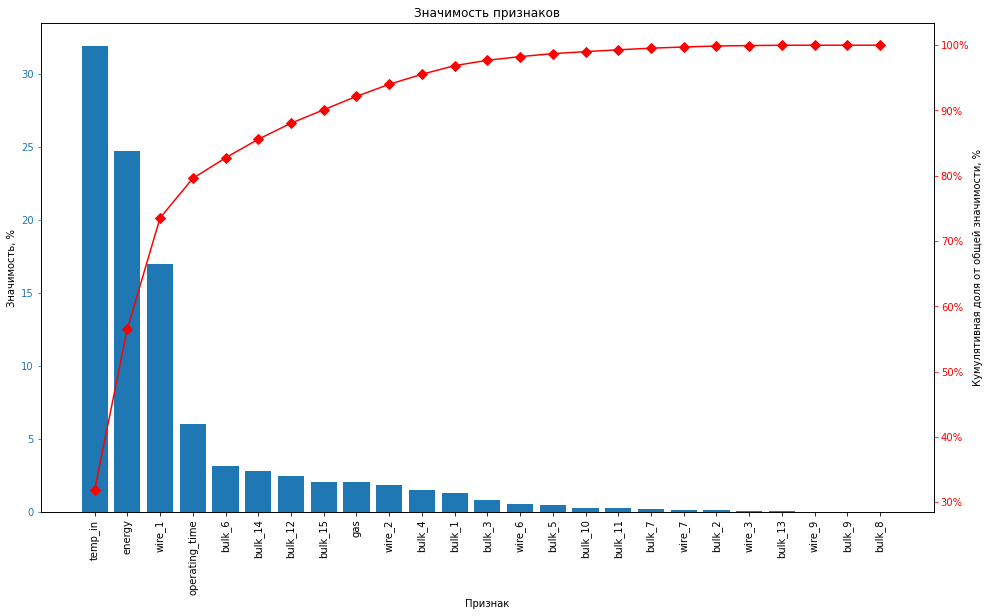

In [104]:
build_pareto(
    cbr_feature_importance,
    'Importances',
    'Значимость признаков',
    'Признак',
    'Значимость, %',
    'Кумулятивная доля от общей значимости, %'
)

###### Вывод

Наиболее значимыми признаками для ***CatBoost Regressor*** являются:

 1. Начальная температура расплава ( ***temp_in*** );
 2. Энергия, затраченная на нагрев расплава ( ***energy*** );
 3. Проволочная добавка первого типа ( ***wire_1*** );
 4. Время, затраченное на обработку расплава ( ***operating_time*** ).
 
Значимость перечисленных признаков составляет ***80%*** от значимости всего набора признаков. Приоритет внимания Заказчика на данном наборе показателей может обеспечить 80% вклада в контролируемость выходной температурой расплава.

В целом, представленная диаграмма может помочь Заказчику устанавливать оптимальные границы контроля показателей.

## Отчет по решению задачи

Заказчик в лице металлургического комбината решил уменьшить потребление электроэнергии в процессе обработки стали. Для этого Заказчику необходима модель машинного обучения, предсказывающая температуру расплава на конечном этапе его обработки. Процесс обработки стали отражен в разделе ***Описание этапа обработки***.

***Задачей*** данного проекта являлась ***разработка прототипа модели машинного обучения***, предсказывающая ***конечную температуру***, замеренную после всех проведенных операций с расплавом, на основании предоставленных Заказчиком данных о процессе обработки стали.

Заказчик предоставил данные, полученные из разных источников, которые включали в себя:

 - данные об электродах;
 - данные о подаче сыпучих материалов (объём);
 - данные о подаче сыпучих материалов (время);
 - данные о продувке сплава газом;
 - результаты измерения температуры;
 - данные о проволочных материалах (объём);
 - данные о проволочных материалах (время).
 
Перед моделированием данные были изучены на предмет наличия пропущенных и аномальных значений, а также на предмет согласованности друг с другом. На основании проведенного анализа была проведена предобработка данных.

***Основной проблемой*** при работе над проектом оказалась ***несогласованность части данных*** в представленных Заказчиком датасетах. Проблема заключалась в том, что ***часть данных об измерении температуры отсутствовала***, и часть операций над расплавом (добавление легирующих элементов и подогрев расплава) приходились на ***временные промежутки вне диапазона между имеющимися первым и последним измерениями температуры***. Такое состояние данных не позволяло выстроить датасет, где каждому целевому признаку соответстсвовал бы четкий набор параметров от начала обработки партии расплава до измерения конечной температуры.

Для решения данной проблемы из датасетов ***были удалены данные по партиям, в которых не было информации о целевом признаке, а также данные, не соответствовавшие временному промежутку между имеющимися первым и последним замерами температуры***. В итоге, обработанные датасеты были объединены в финальный датасет, где каждый объект содержал в себе информацию о первоначальной температуре расплава, операциях, проводимых с расплавом и конечной температуре, являвшейся целевым признаком. Несмотря на ***потерю 27%*** данных, такая архитектура датасета позволила провести корректное моделирование с учетом только взаимосвязанных признаков и получить адекватный результат.

Далее был проведен исследовательский анализ данных, где были изучены статистики и распределения значений. ***Одним из ключевых моментов***, позволившим положительно повлиять на качество итоговой модели машинного обучения, оказалось ***обнаружение и удаление*** из объединенного датасета ***объектов с начальной температурой расплава менее 1300 °C***, нехарактерной для плавления основных видов стали и являющейся, по информации Заказчика, несвойственной для производства.

Предобработанные данные были разделены на две выборки: обучающую и тестовую в соотношении ***75% : 25%***, масштабированы для исключения придания моделями машинного обучения больших весов признакам с большими значениями и очищены от сильно коррелирующих пар признаков ( ***К ≥ 0.7*** ) путем удаления одного признака из пары.

Выборки были использованы для подбора, обучения и тестирования моделей: ***Дерево решений***, ***Случайный лес***, ***Линейная регрессия***, ***XGBoost Regressor***, ***LightGBM Regressor***, ***CatBoost Regressor***.

В соответствии с условиями задачи целевой метрикой качества моделей была выбрана средняя абсолютная ошибка ***MAE*** (*англ. Mean Absolute Error*).

Для подбора гиперпараметров, а также предварительной оценки качества моделей методом кросс-валидации был применен ***GridSearchCV***.

В результате подбора моделей были выбраны три наиболее перспективных:

  1. ***CatBoost Regressor***; 
  2. ***XGBoost Regressor***;
  3. ***LightGBM Regressor***.
  
которые были протестированы на скорость обучения и качество предсказаний на тестовой выборке.

Наилучшей с точки зрения требований заказчика оказалась модель ***CatBoost Regressor*** со следующими гиперпараметрами:

 - ***iterations*** = ***437***;
 - ***learning_rate*** = ***0.06***.

Полученное значение ***MAE*** модели на тестовой выборке = ***5.75 °С***, что удовлетворяет требования Заказчика ( ***MAE ≤ 6*** ) по значению метрики качества.

Метрика качества означает, что модель предсказывает конечную температуру расплава со средней разностью между предсказанными и фактическими значениями в ***5.75 °С***.

Также с помощью ***CatBoost Regressor*** была определена значимость влияния признаков на целевой. Ниже отражен ***ТОП-3*** в порядке убывания значимости:

1. Начальная температура расплава;
2. Энергия, затраченная на нагрев расплава;
3. Масса проволочной добавки типа 1.

Работа выполнялась согласно плана, отраженного в разделе ***План выполнения работы***. Все пункты плана выполнены.